# Standard Workflow

In this notebook, we present the standard workflow, using defaults set in the plugin in terms of data format, segmentation approach etc.

We start here with the standard interface:

In [1]:
%load_ext autoreload
%autoreload 2

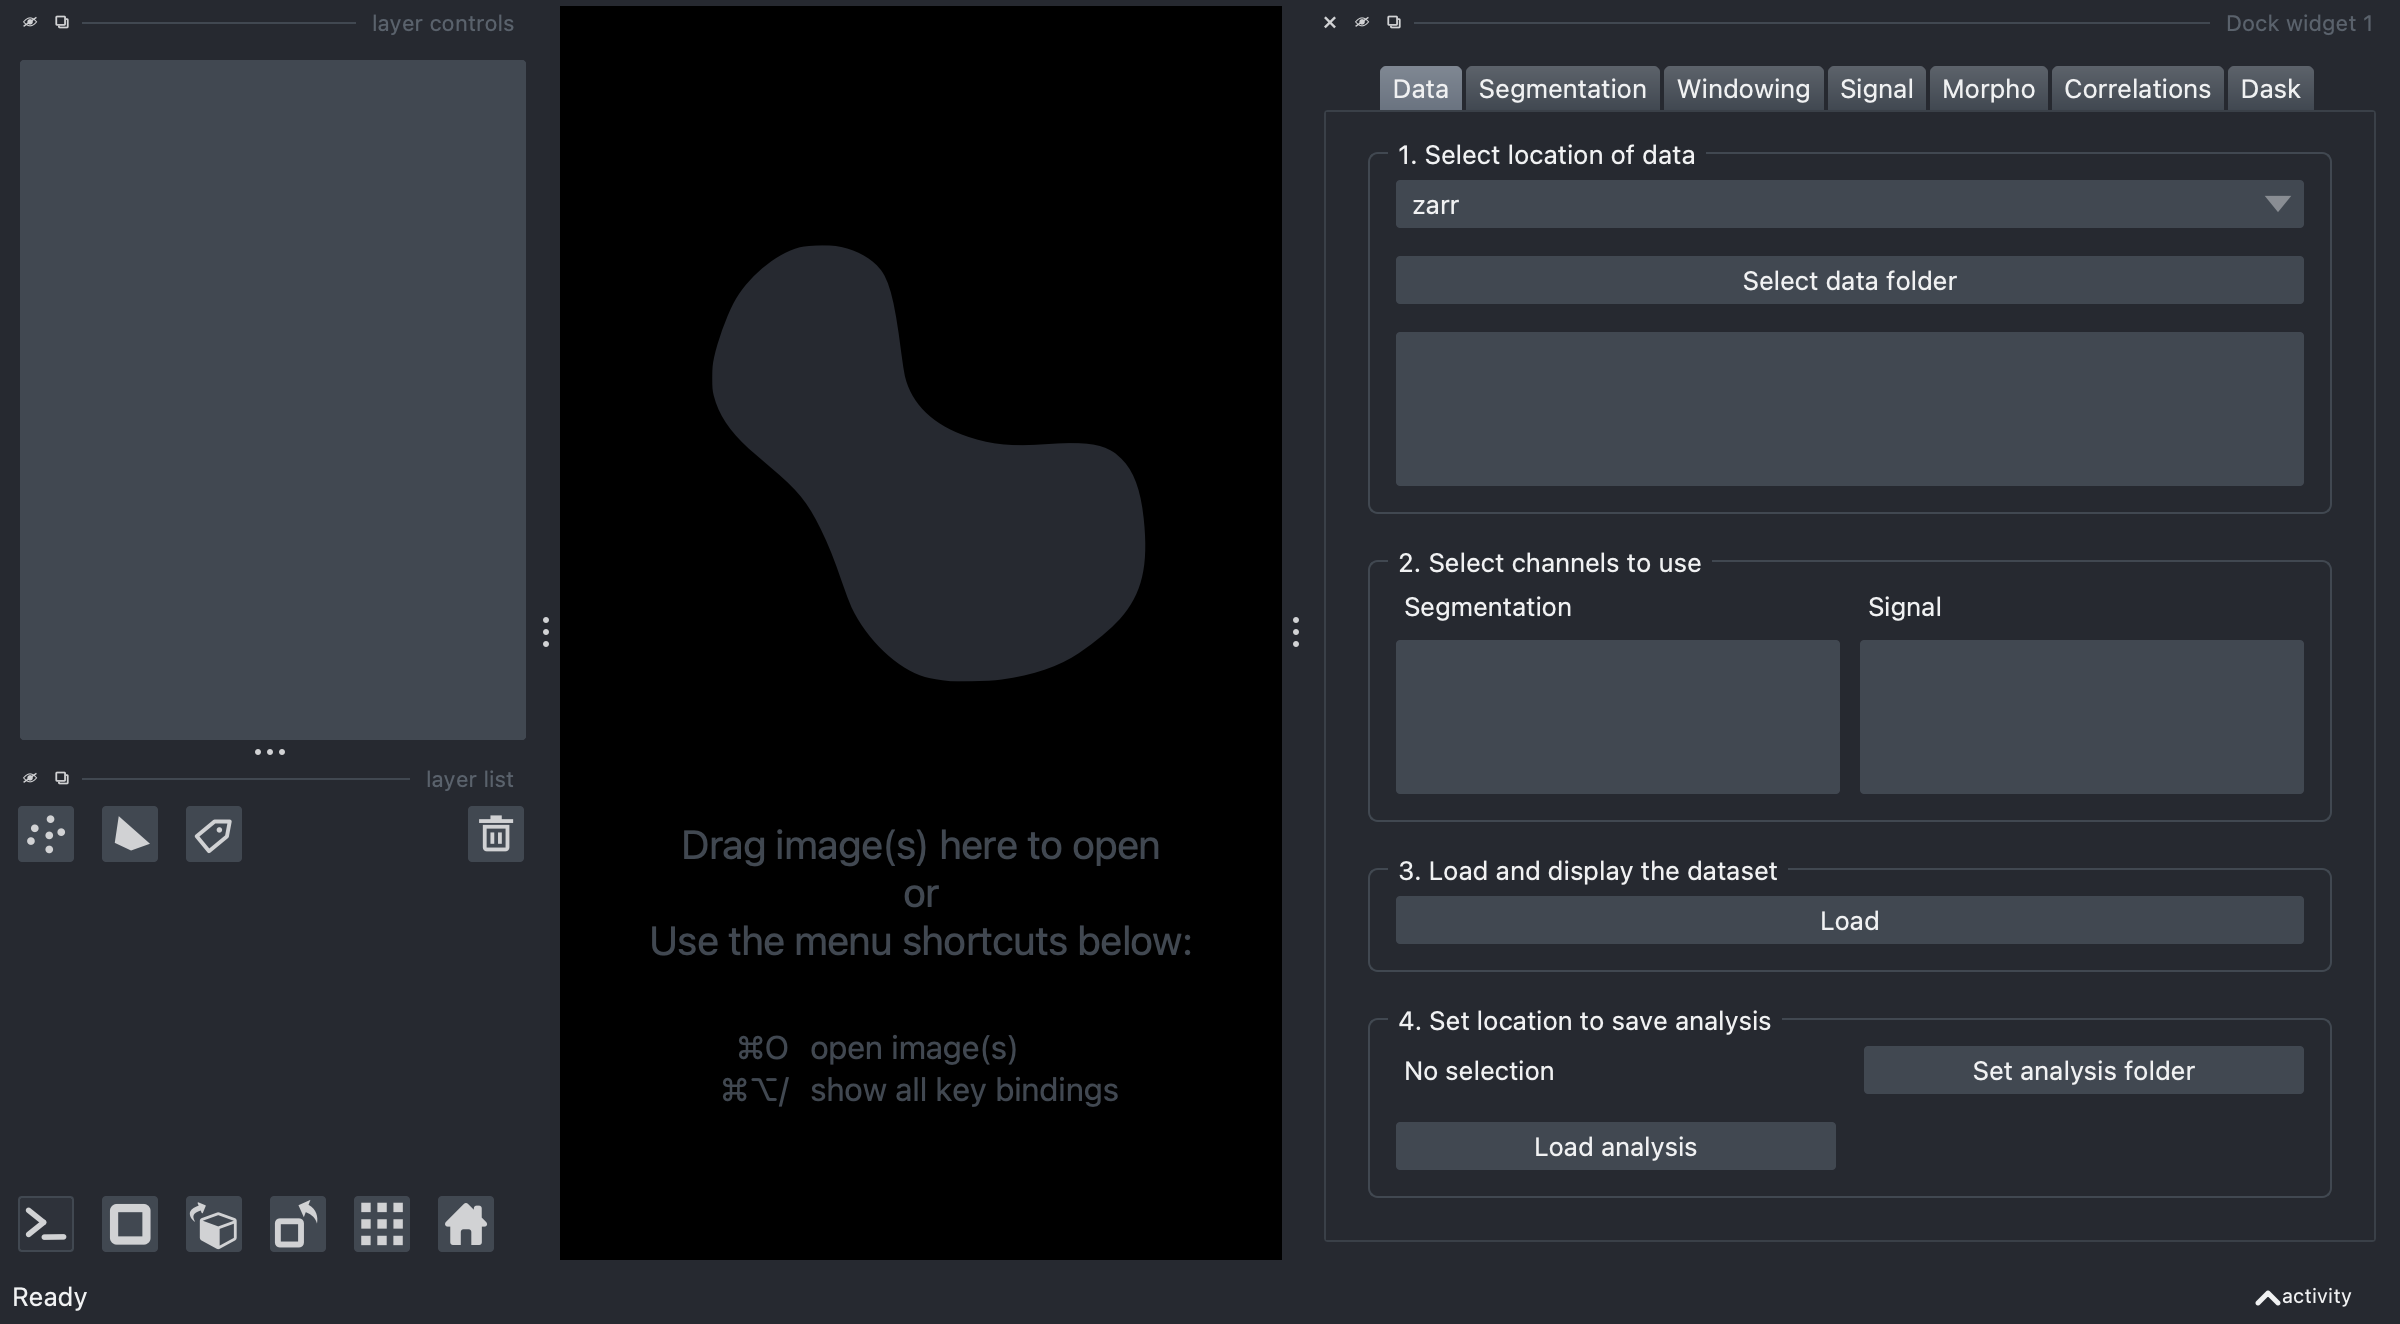

In [2]:
import napari
import skimage
import numpy as np
from napari.utils import nbscreenshot
from napari_morphodynamics.napari_gui import MorphoWidget
from qtpy.QtWidgets import QLabel, QSizePolicy

viewer = napari.Viewer()
viewer.window.resize(1200,400)
self = MorphoWidget(viewer)

self.setMaximumWidth(550)

viewer.window.add_dock_widget(self)
nbscreenshot(viewer)

## Loading data

The type of data to load can be selected in the first step ```1. Select location of data```. Here we use the zarr format. Then we select the actual data by clicking on ```Select data folder```:

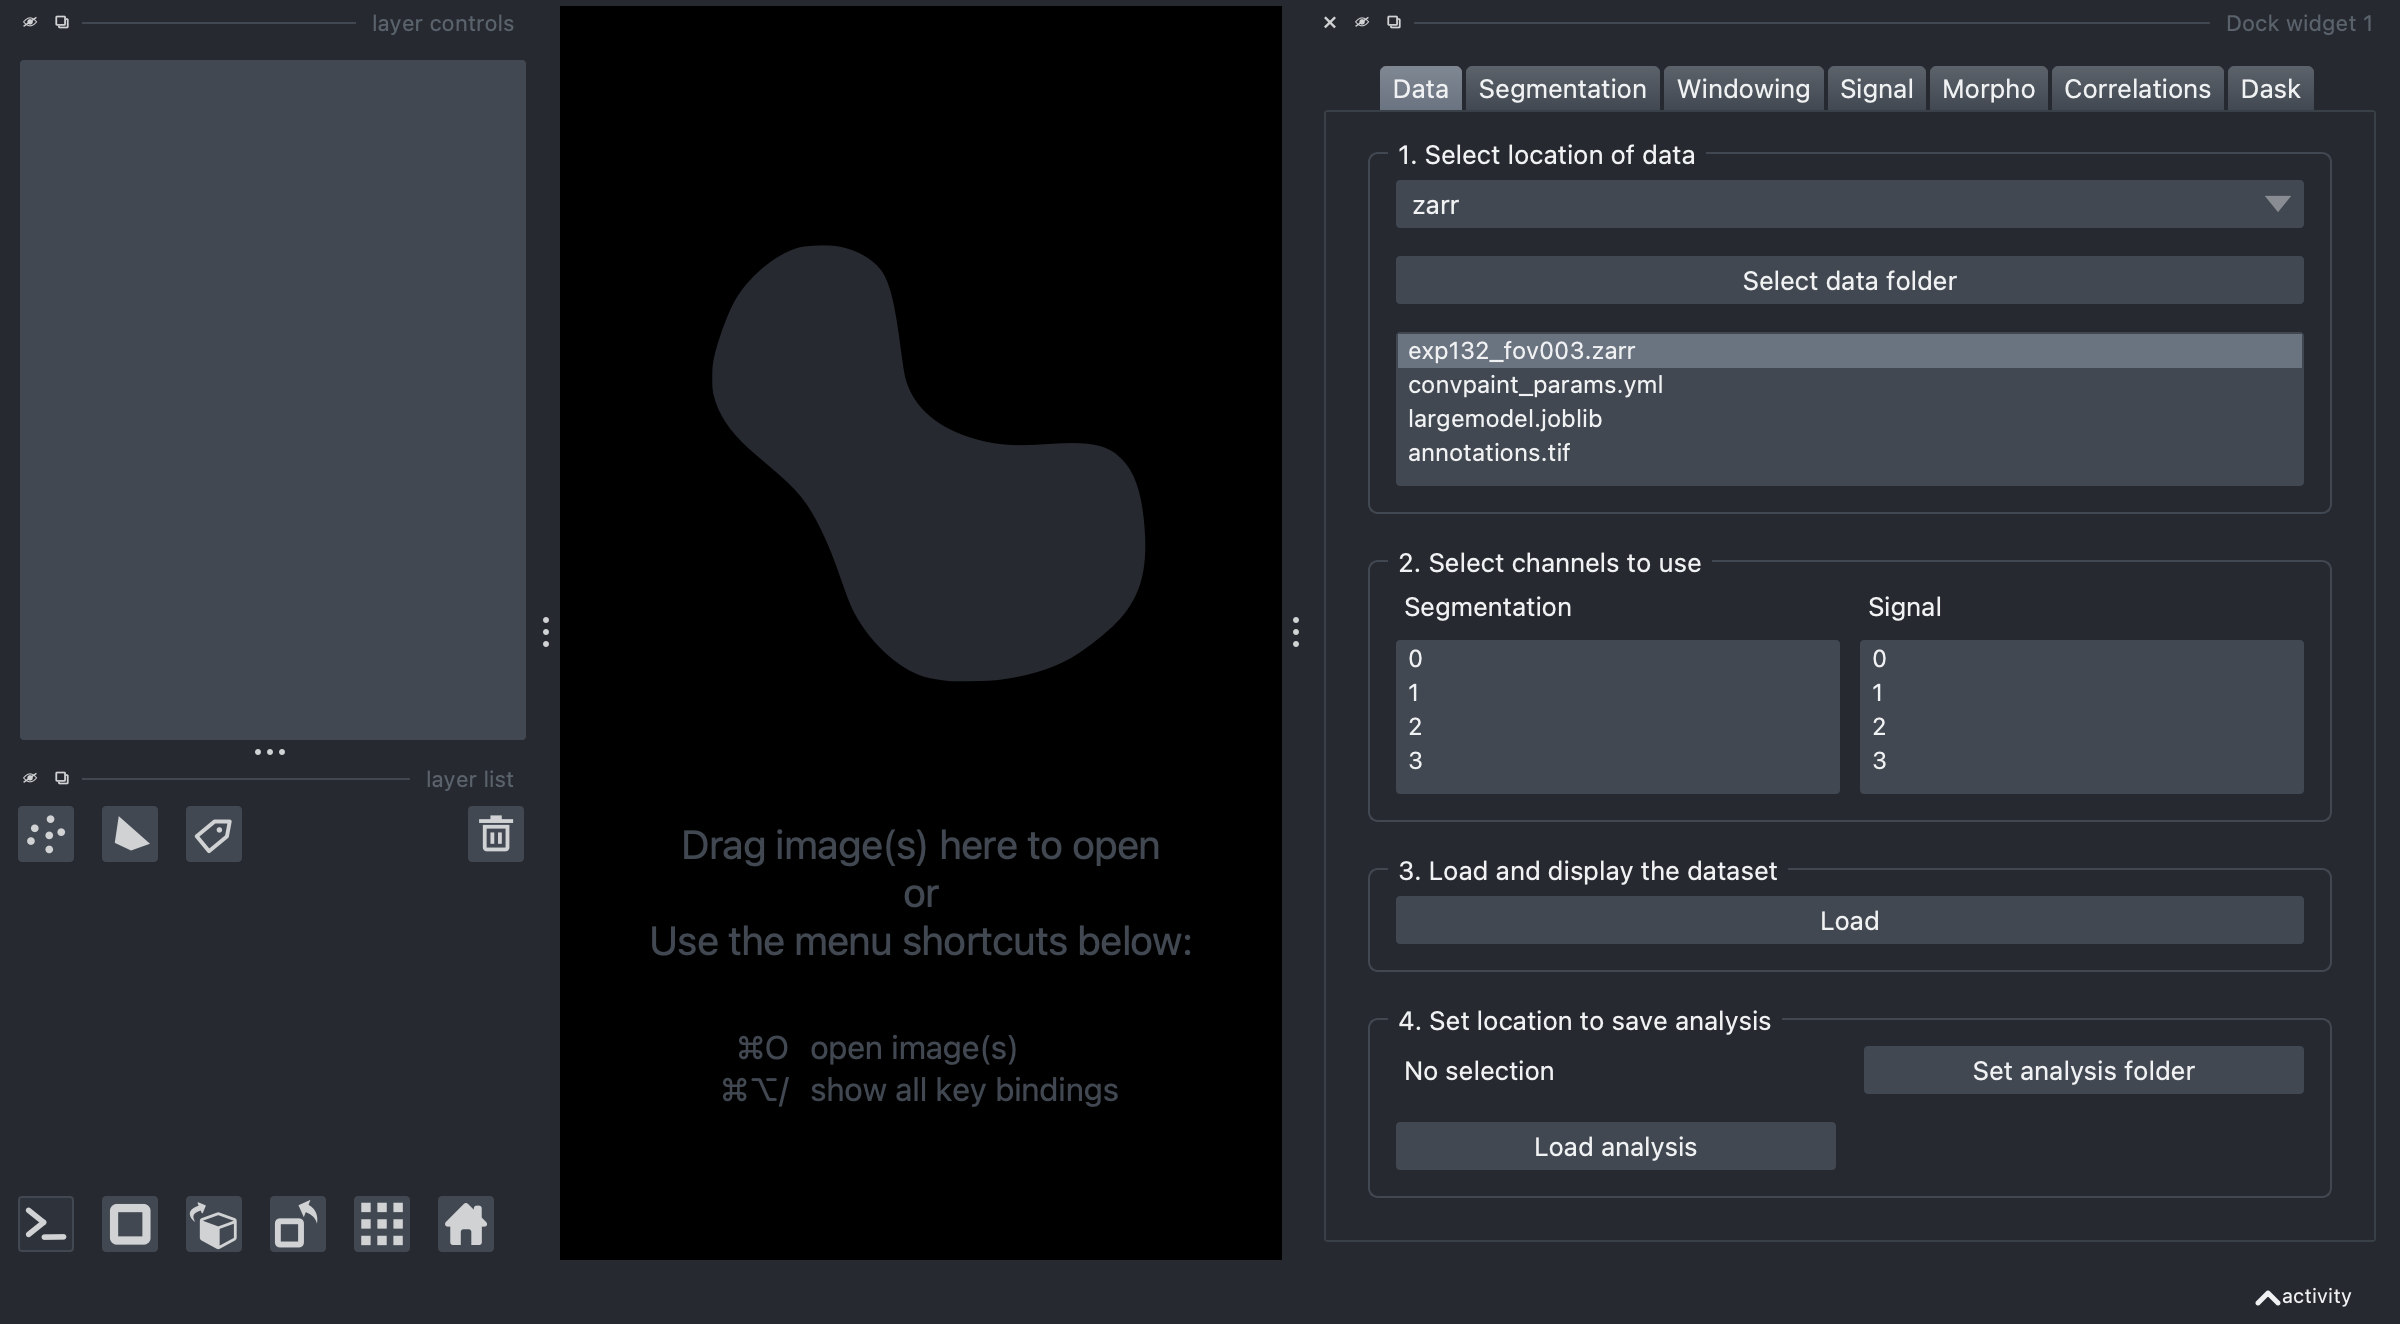

In [3]:
self._on_click_select_file_folder(
#    file_folder='../../../Projects_data/napari-morphodynamics/cell_small_zarr/exp132.zarr/')
    file_folder='../../../Projects_data/napari-morphodynamics/cell_large_zarr/exp132_fov003.zarr/')
nbscreenshot(viewer)

As can be seen in the second section ```Select channels to use```, when a correctly formated dataset is selected, the plugin reads information about the data to give the choice of channels to use. Note that usually this doesn't acutally load the data in memory. Here we use the channel ```0``` for segmentation and keep all channels for analysis. Then we can go to the third step ```3. Load and display dataset``` which will load the data in the viewer. Finally, we need to specify where to save the analyzed data and parameters in ```4. Set location to save analysis```.

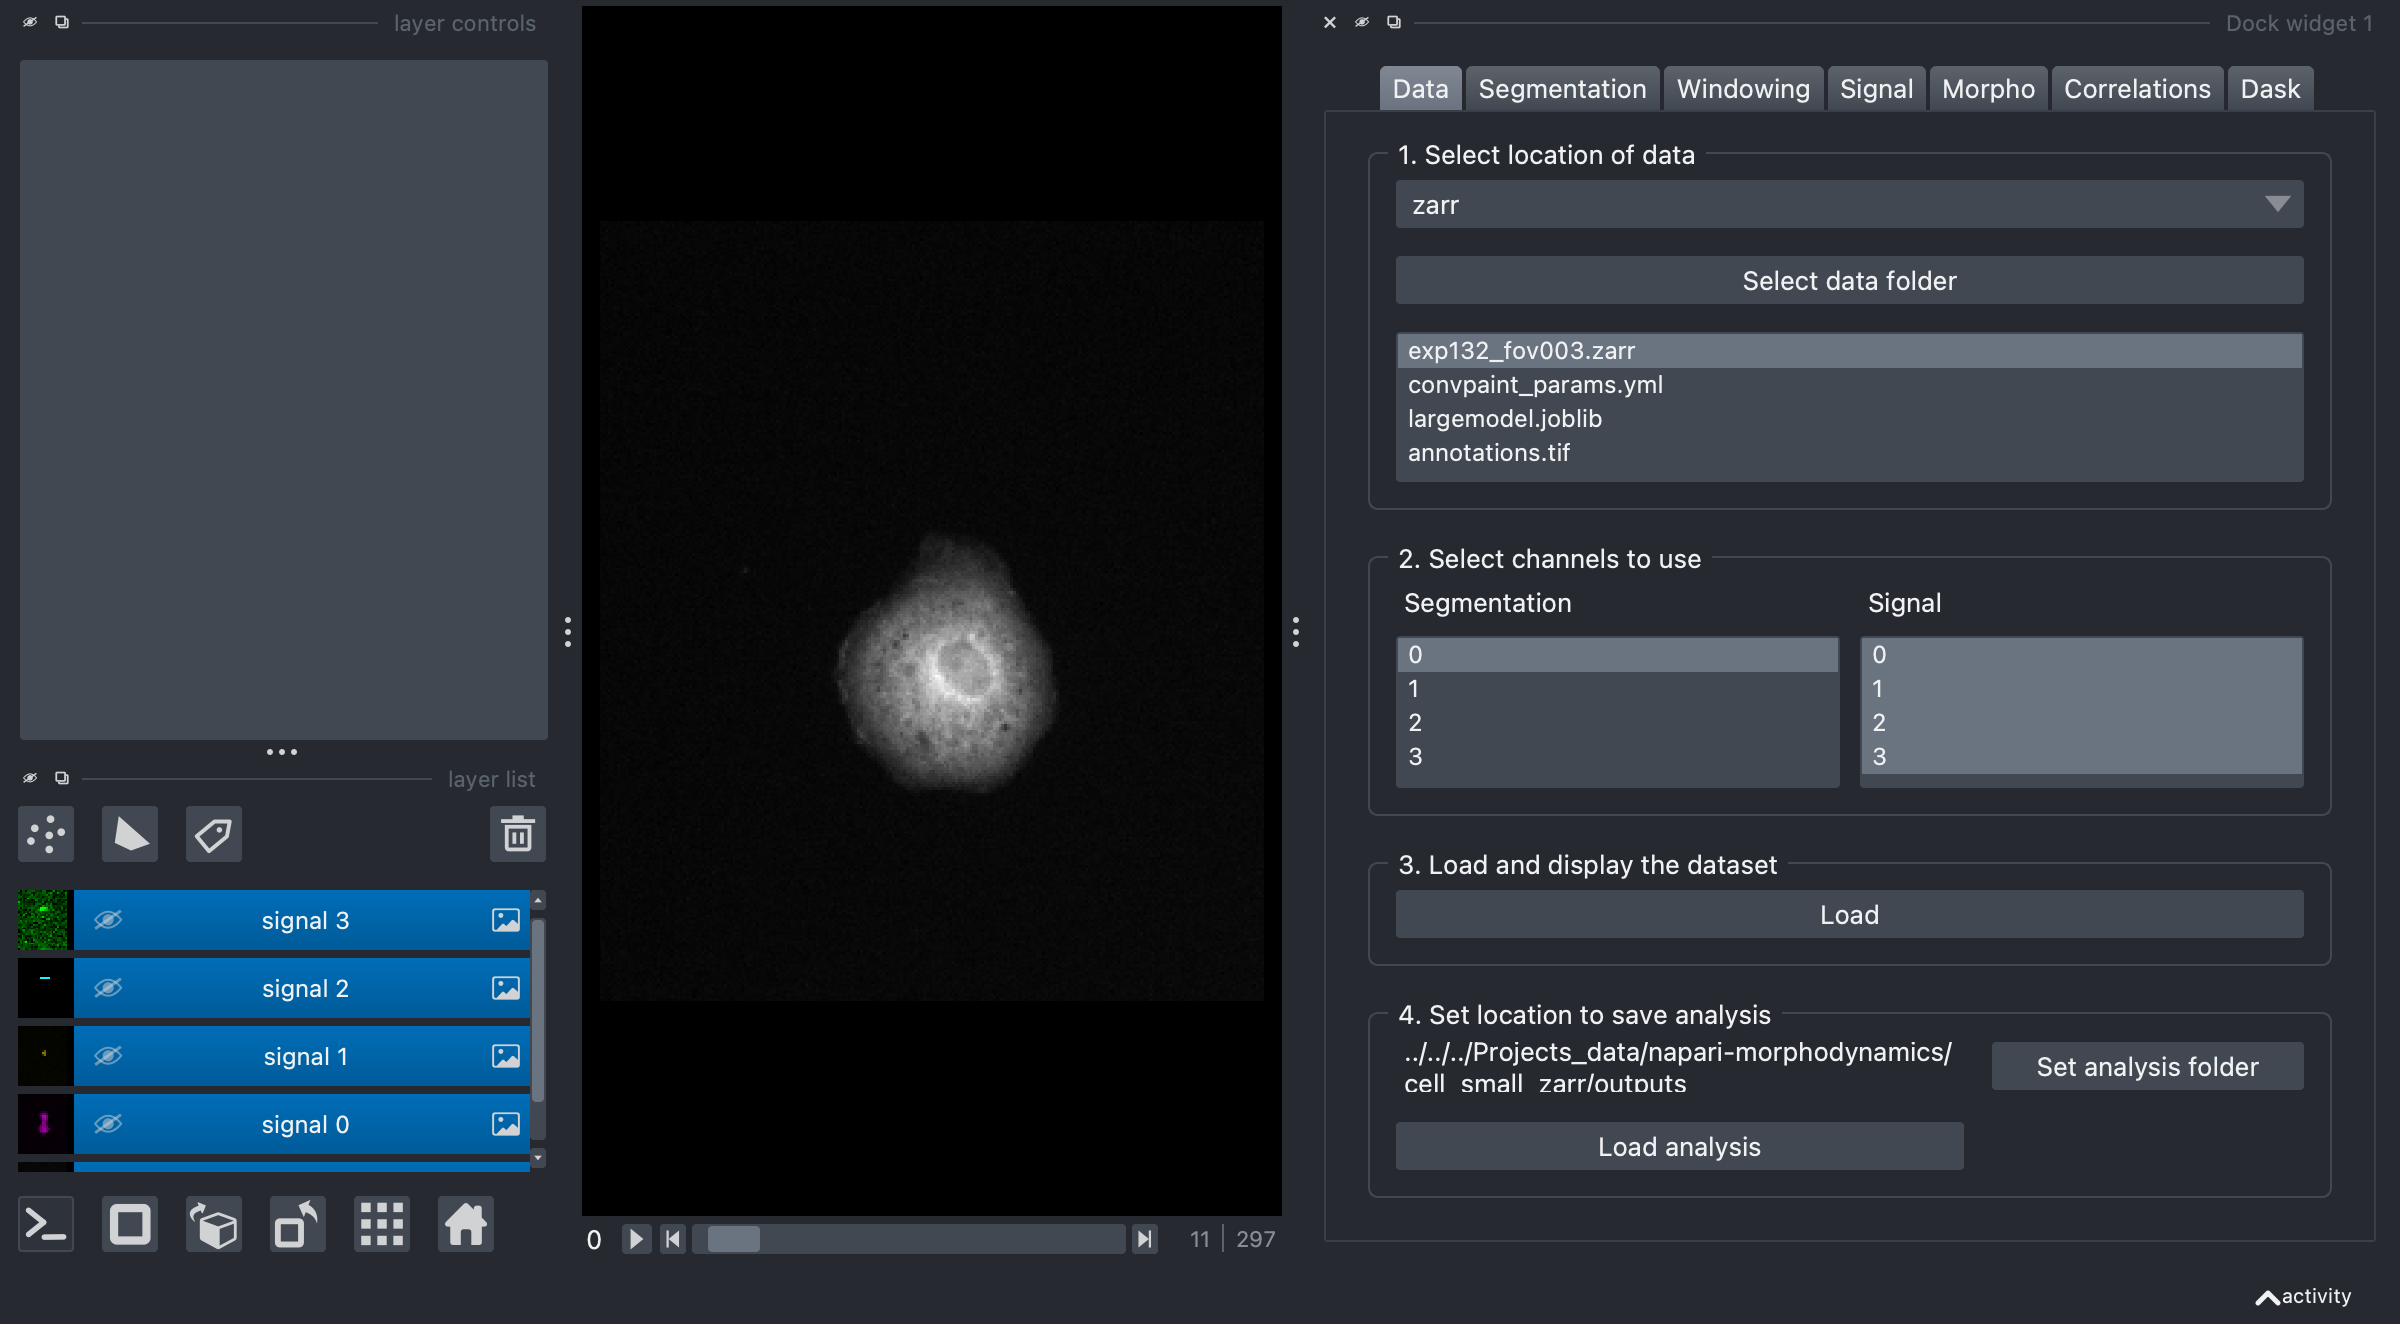

In [4]:
self.segm_channel.setCurrentRow(0)
for i in range(4):
    self.signal_channel.item(i).setSelected(True)
self._on_load_dataset()


from pathlib import Path
import os
analysed_folder = Path('../../../Projects_data/napari-morphodynamics/cell_small_zarr/outputs/')
os.makedirs(analysed_folder, exist_ok=True)

self._on_click_select_analysis(analysis_path=analysed_folder)

viewer.layers['signal 3'].contrast_limits = [100, 150]
viewer.layers.select_all()
viewer.layers.toggle_selected_visibility()
viewer.layers['0'].visible = True
viewer.dims.current_step = (11,134,114)

nbscreenshot(viewer)

## Segmentation

The next steps is segmentation. Here our default mode is to use the napari-convpaint plugin, which allows to create reasonable segmentations in a few brush strokes. First we need to pick the channel to use for segmentation, here ```0```. Then we click on ```Add annotation/predict layers``` so that we can add annotations. Using the brush in the ```annotations``` labels layer, we indicate background regions with index 1 and foreground (cell) with index 2:

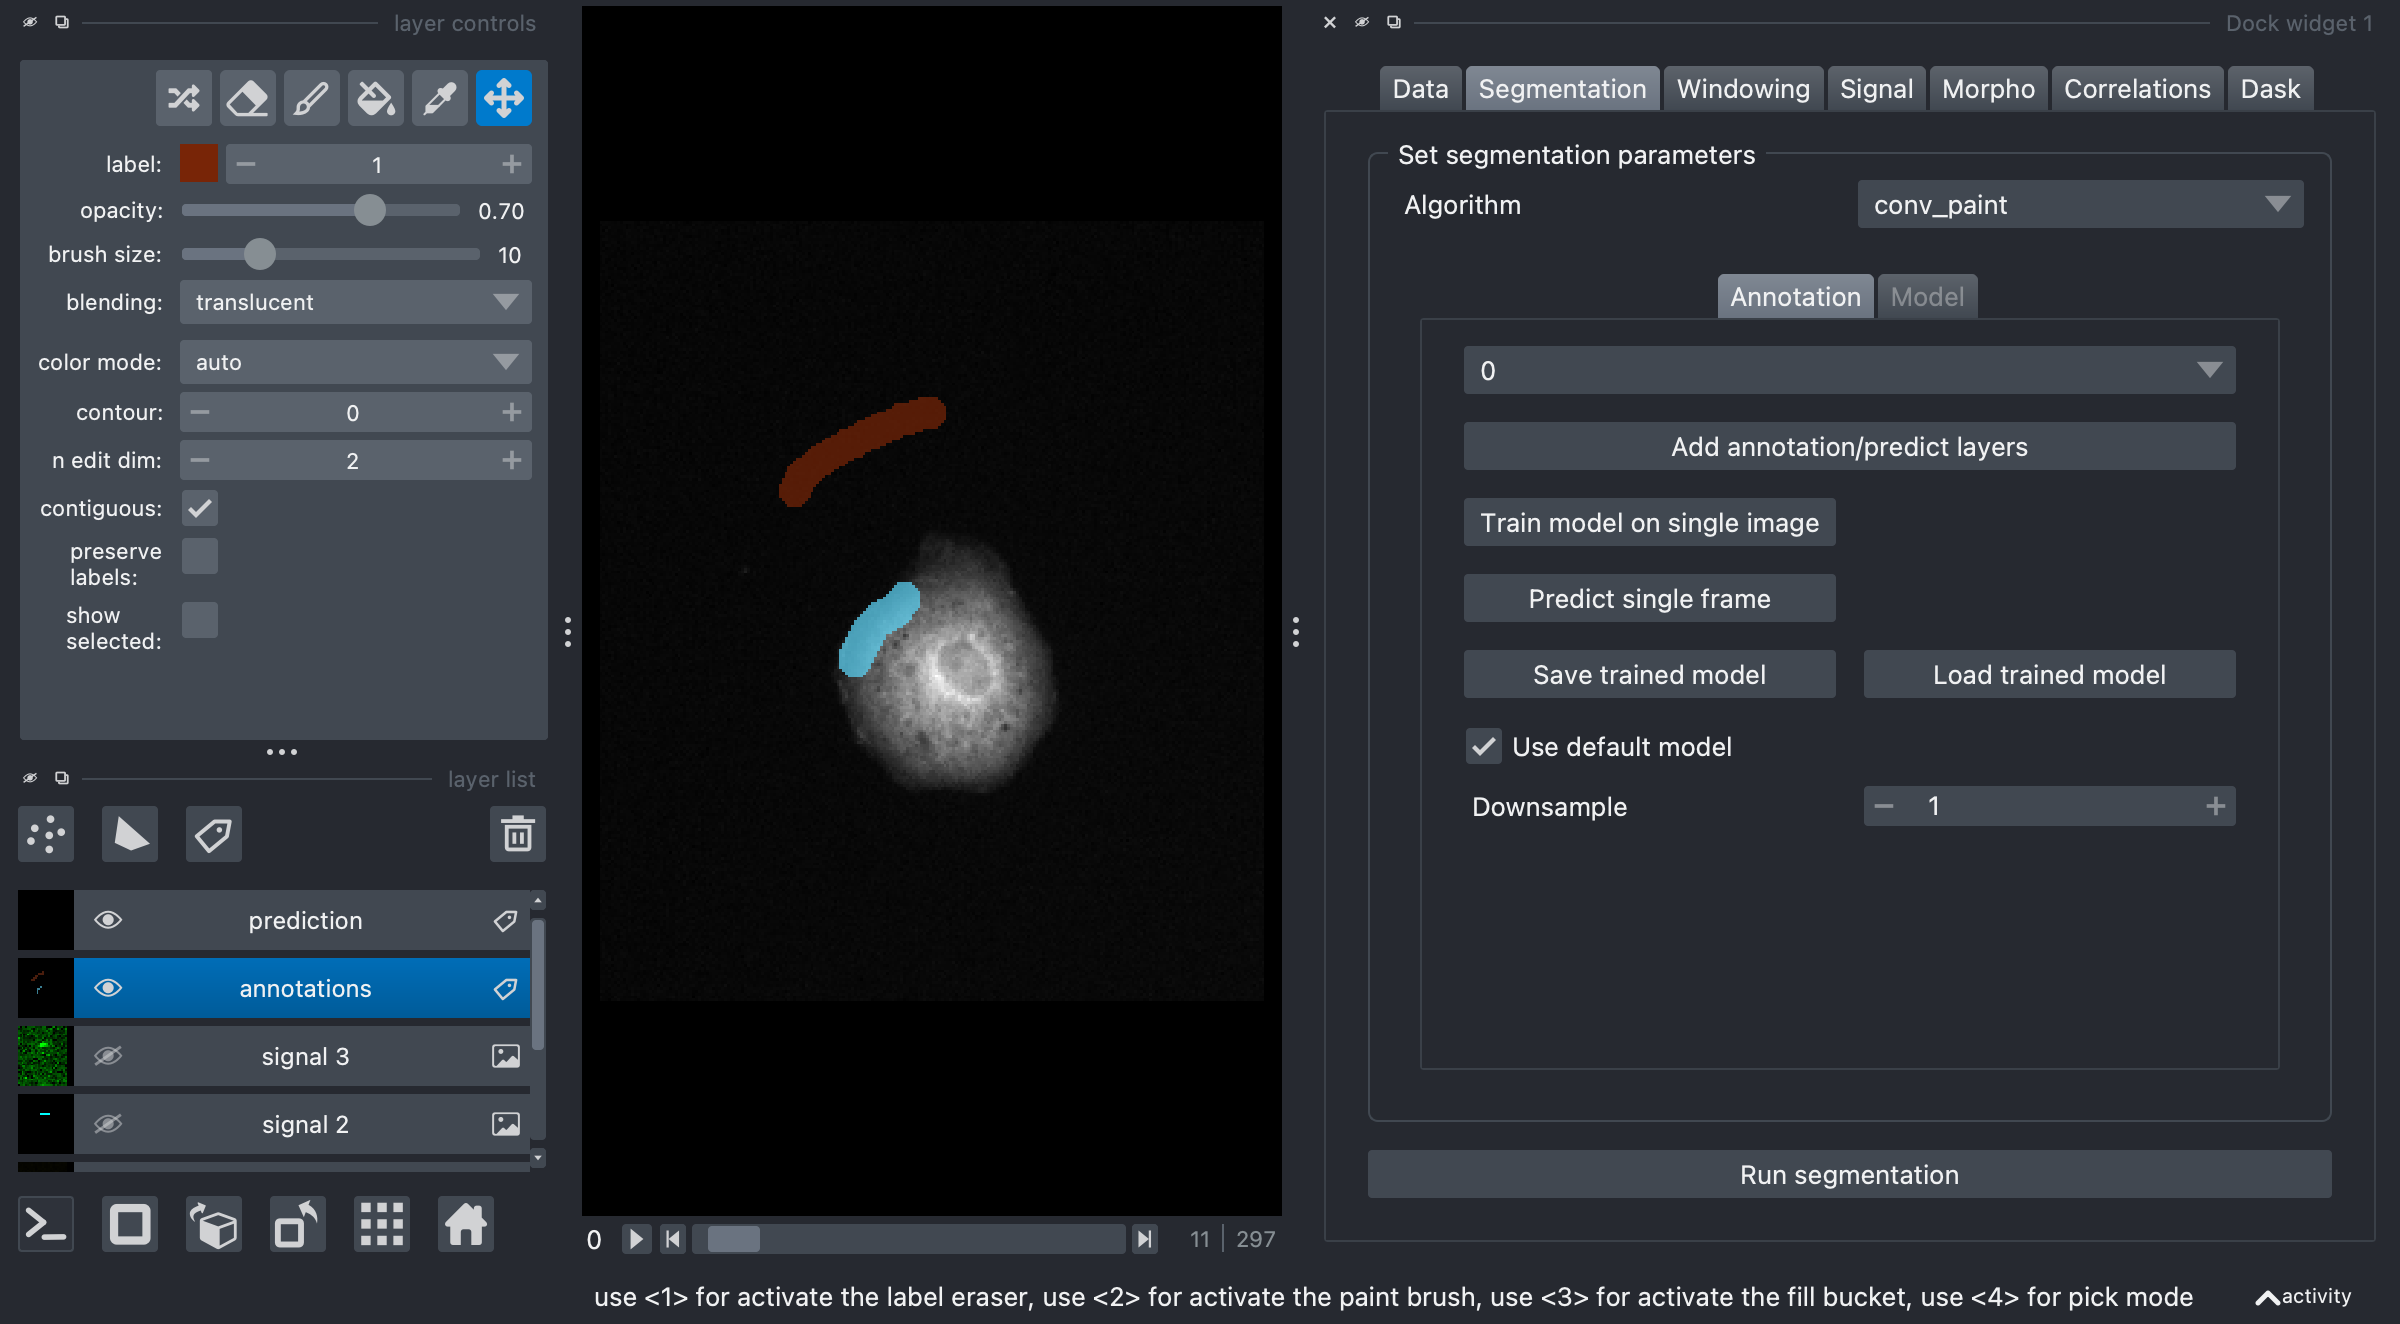

In [5]:
self.tabs.setCurrentIndex(1)
self.conv_paint_widget.add_annotation_layer()
#labels = skimage.io.imread('../../../Projects_data/napari-morphodynamics/cell_small_zarr/annotations.tif')
labels = skimage.io.imread('../../../Projects_data/napari-morphodynamics/cell_large_zarr/annotations.tif')
viewer.layers['annotations'].data = labels
nbscreenshot(viewer)

In [6]:
"""import skimage
skimage.io.imsave('../../../Projects_data/napari-morphodynamics/cell_large_zarr/annotations.tif',
                  viewer.layers['annotations'].data, check_contrast=False)
"""

"import skimage\nskimage.io.imsave('../../../Projects_data/napari-morphodynamics/cell_large_zarr/annotations.tif',\n                  viewer.layers['annotations'].data, check_contrast=False)\n"

Then we can train the pixel classififer so that we can segement the whole movie. Before we segment all images we can have a first look by selecting ```Predict single frame``` and correct the annotations if necessary.

In [7]:
self.conv_paint_widget.update_classifier()
self.conv_paint_widget.predict()

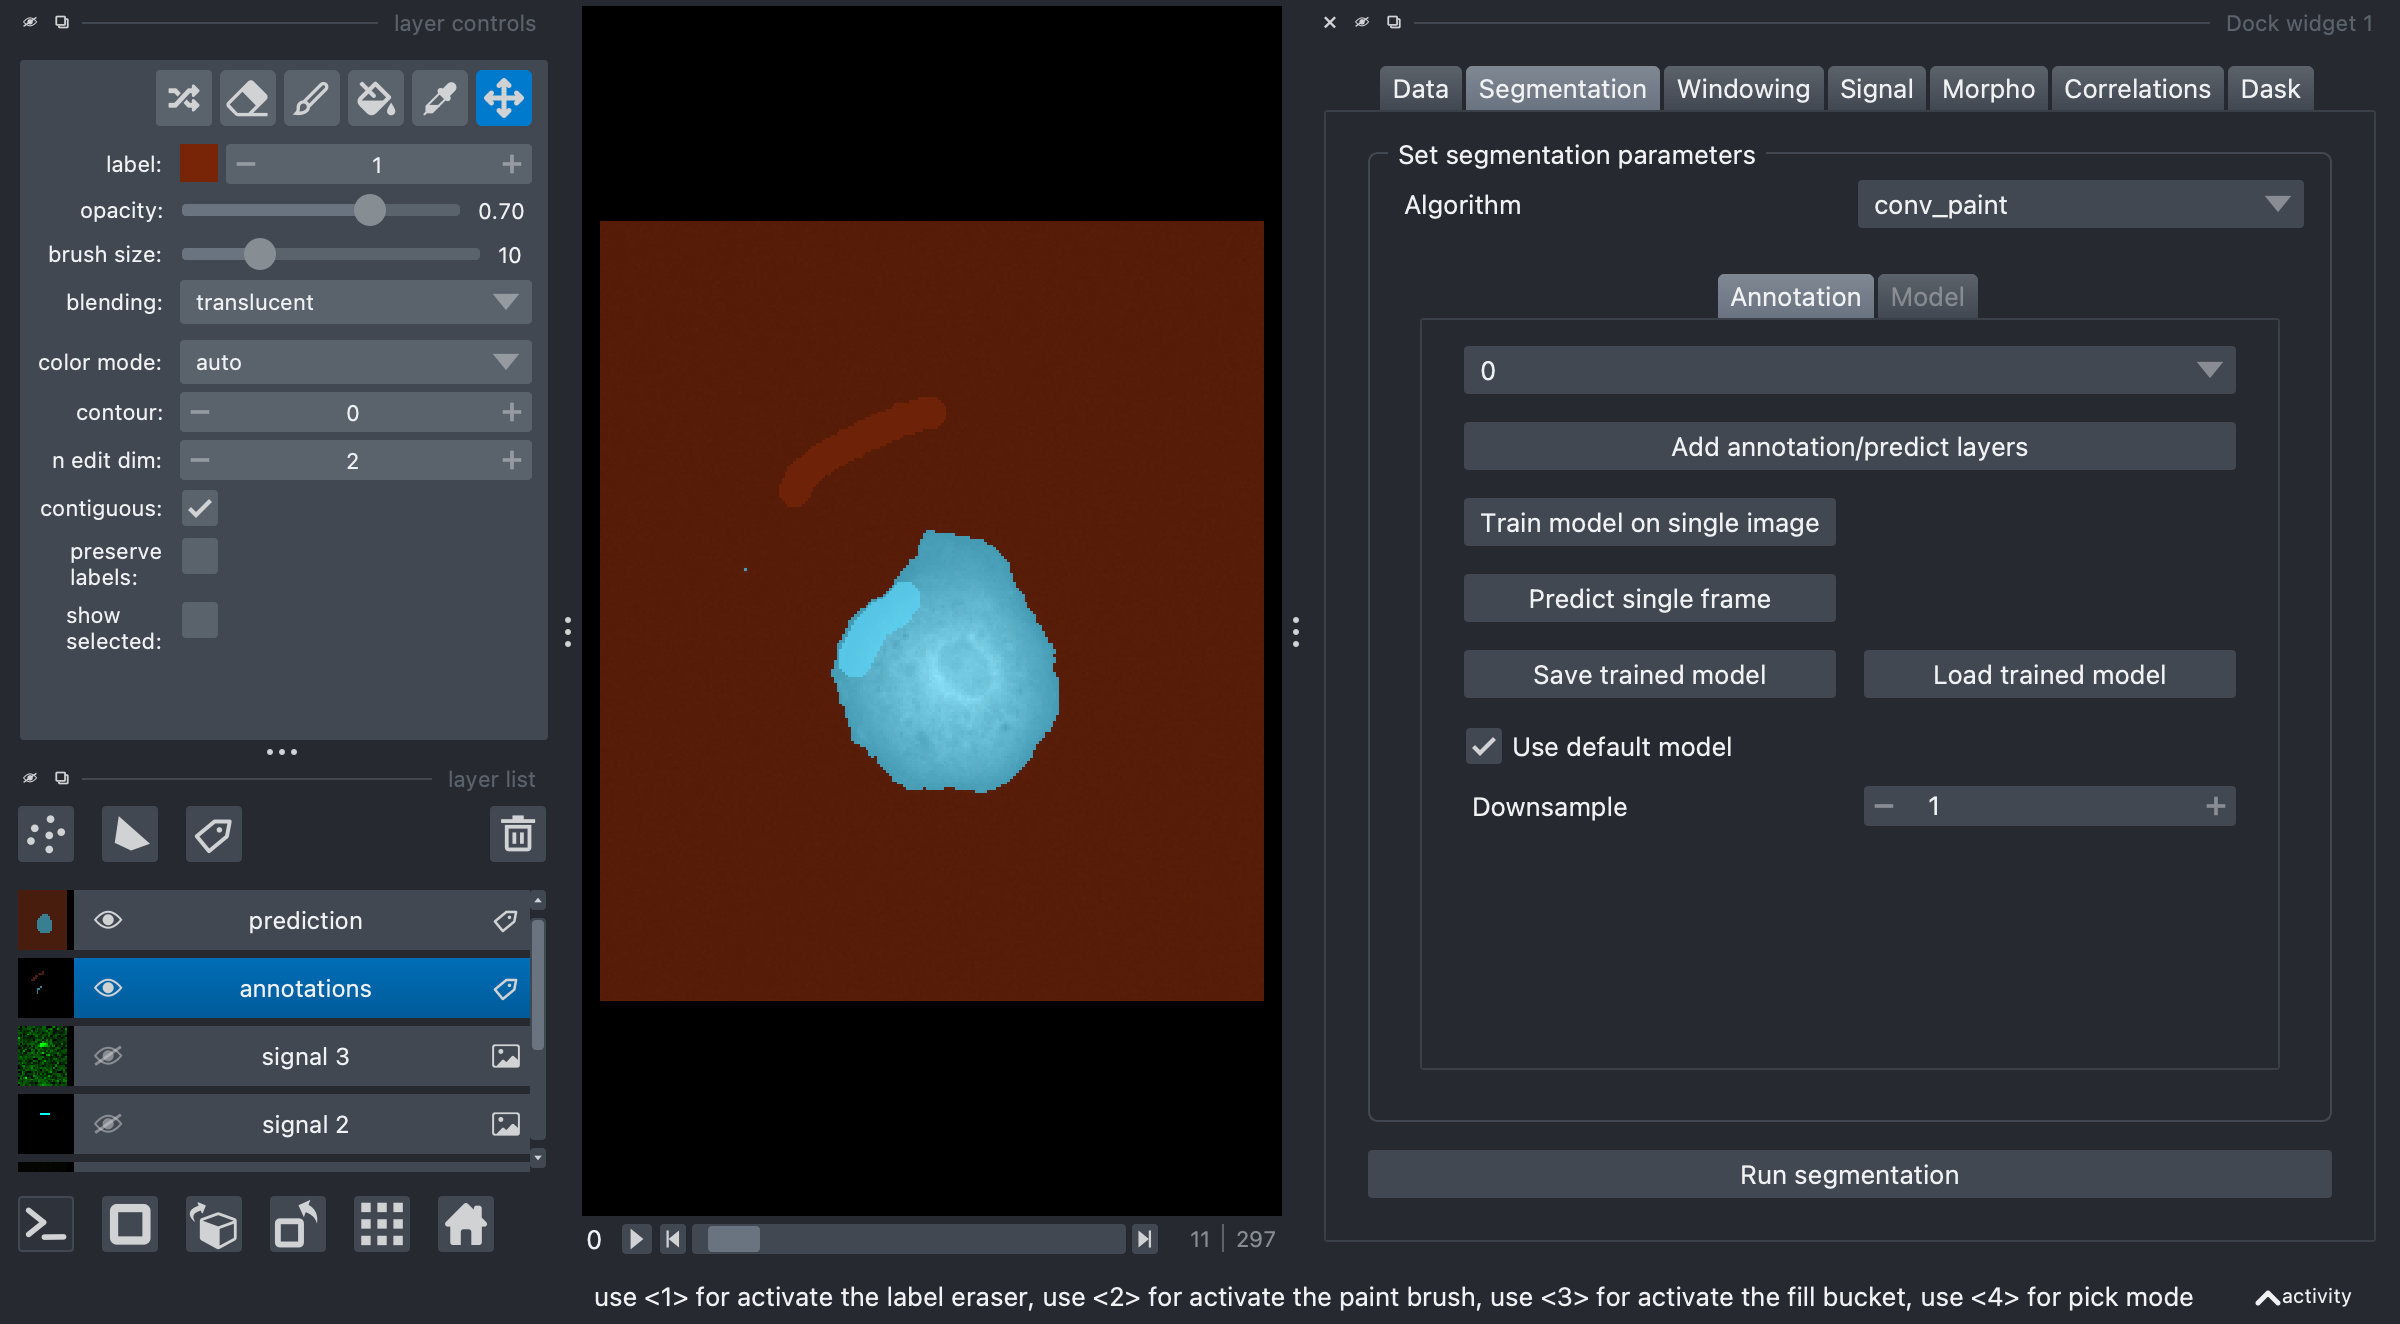

In [8]:
nbscreenshot(viewer)

If we are satisfied, we can click on ```Run segmentation``` which applies the same classifier to all frames. Additionally, in this step, we do some basic tracking of the cell in case multiple objects are segmented. Note that the first time we segment the time-lapse, we are prompted to indicate where to save the classifier (we recommend to leave it in the analysis folder).

In [7]:
self._on_run_segmentation()

frame segmentation: 100%|██████████████████████████████| 298/298 [03:23<00:00,  1.46it/s]
/Users/gw18g940/mambaforge/envs/naparimorpho_test1/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65530 instead
  warnings.warn(


Segmentation data get saved automatically in the analysis folder.

## Windowing

Our goal is to track the internal cell dynamics. For that we need to break up the cell in multiple small windows in which we can then integrate the intensity. Windows are created in concentric layers. We can set the desired dimensions of the window and the algorithm computes the optimal number of layers and windows per layer. Here we keep the defaults. Here again, we can run windowing on a single image, as a check. When ready, we can run the windowing for the entire movie.

frames compute windows:   0%|                                    | 0/298 [00:00<?, ?it/s]/Users/gw18g940/GoogleDrive/BernMIC/Projects/MorphoDynamics/morphodynamics/analysis_par.py:457: RuntimeWarning: invalid value encountered in cast
  skimage.io.imsave(name2, b0.astype(np.uint8), check_contrast=False)
/Users/gw18g940/GoogleDrive/BernMIC/Projects/MorphoDynamics/morphodynamics/analysis_par.py:457: RuntimeWarning: invalid value encountered in cast
  skimage.io.imsave(name2, b0.astype(np.uint8), check_contrast=False)
/Users/gw18g940/GoogleDrive/BernMIC/Projects/MorphoDynamics/morphodynamics/analysis_par.py:457: RuntimeWarning: invalid value encountered in cast
  skimage.io.imsave(name2, b0.astype(np.uint8), check_contrast=False)
/Users/gw18g940/GoogleDrive/BernMIC/Projects/MorphoDynamics/morphodynamics/analysis_par.py:457: RuntimeWarning: invalid value encountered in cast
  skimage.io.imsave(name2, b0.astype(np.uint8), check_contrast=False)
frames compute mapping: 100%|██████████████████

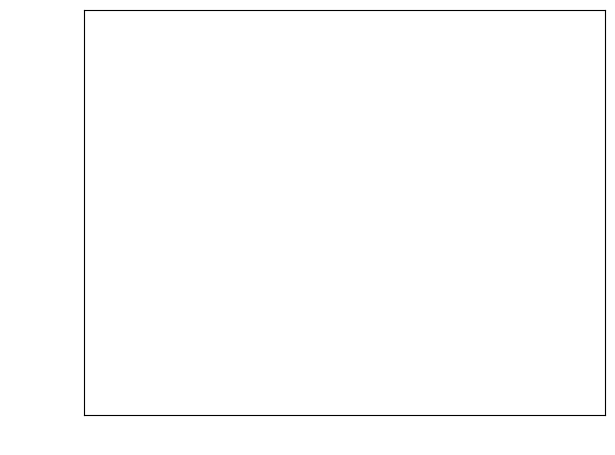

In [8]:
self.tabs.setCurrentIndex(2)
self._on_run_spline_and_window()

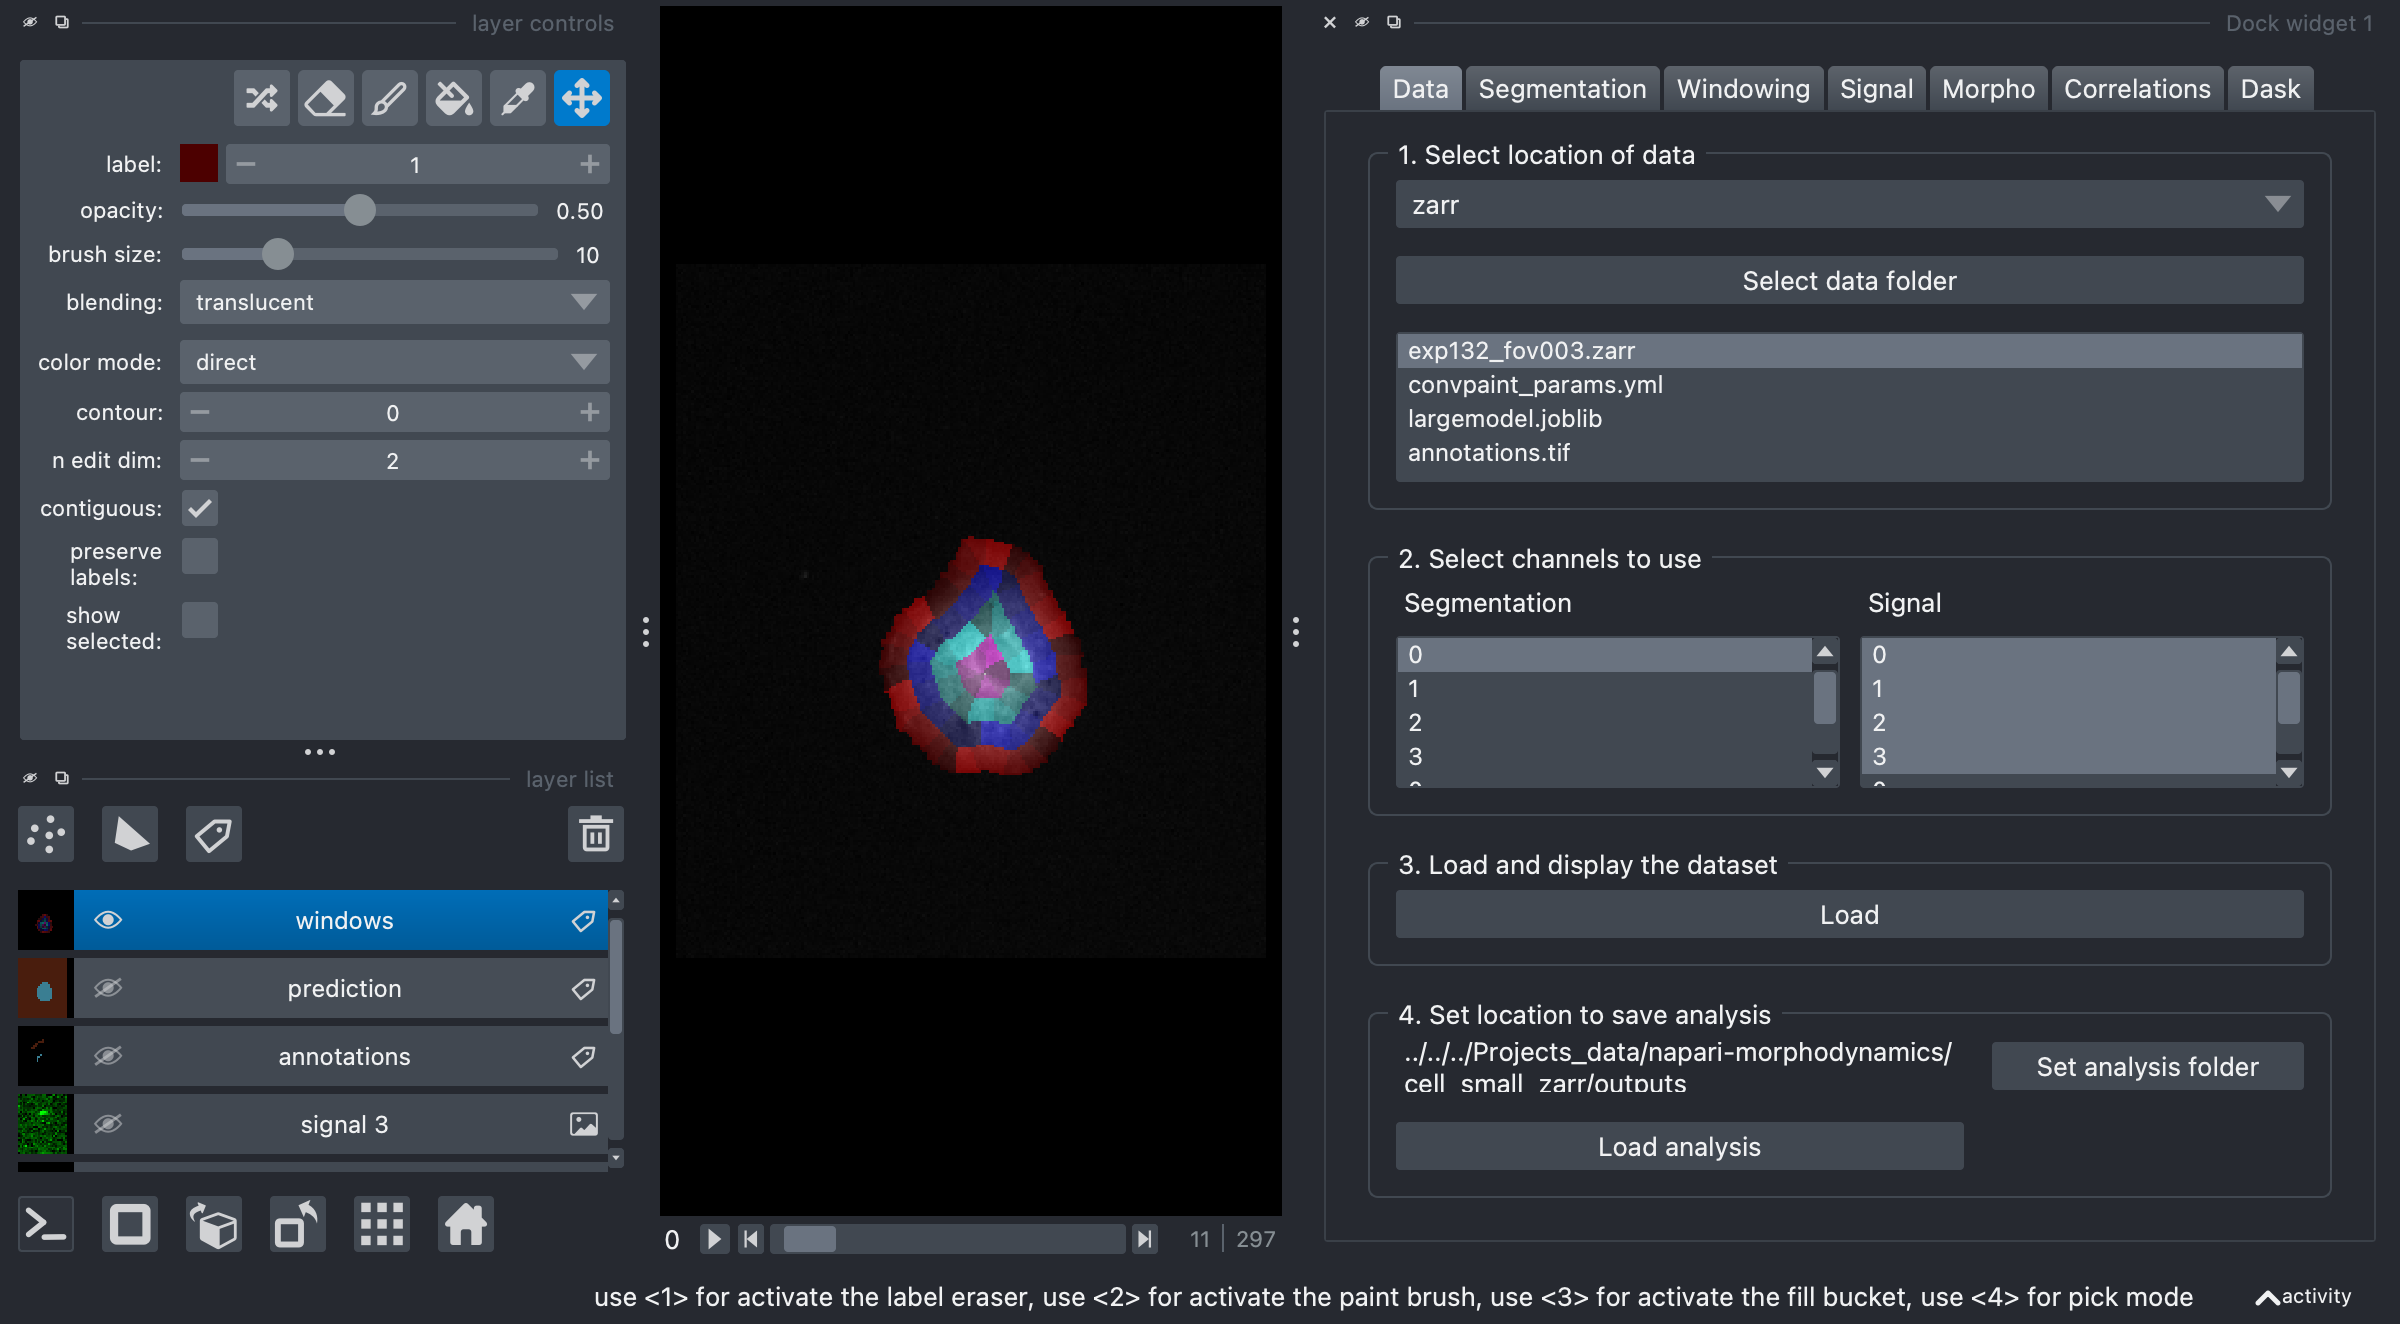

In [10]:
viewer.layers['prediction'].visible = False
viewer.layers['annotations'].visible = False
#viewer.layers['segmentation'].visible = False
viewer.layers['windows'].opacity = 0.5
nbscreenshot(viewer)

## Visualizations

In the ```Display Options``` tab we can visualize intensity per window plots. The horizontal axis represents time, while the vertical one corresponds to a window index. We can select which layer we went to visualize at the top and the channel at the bottom:

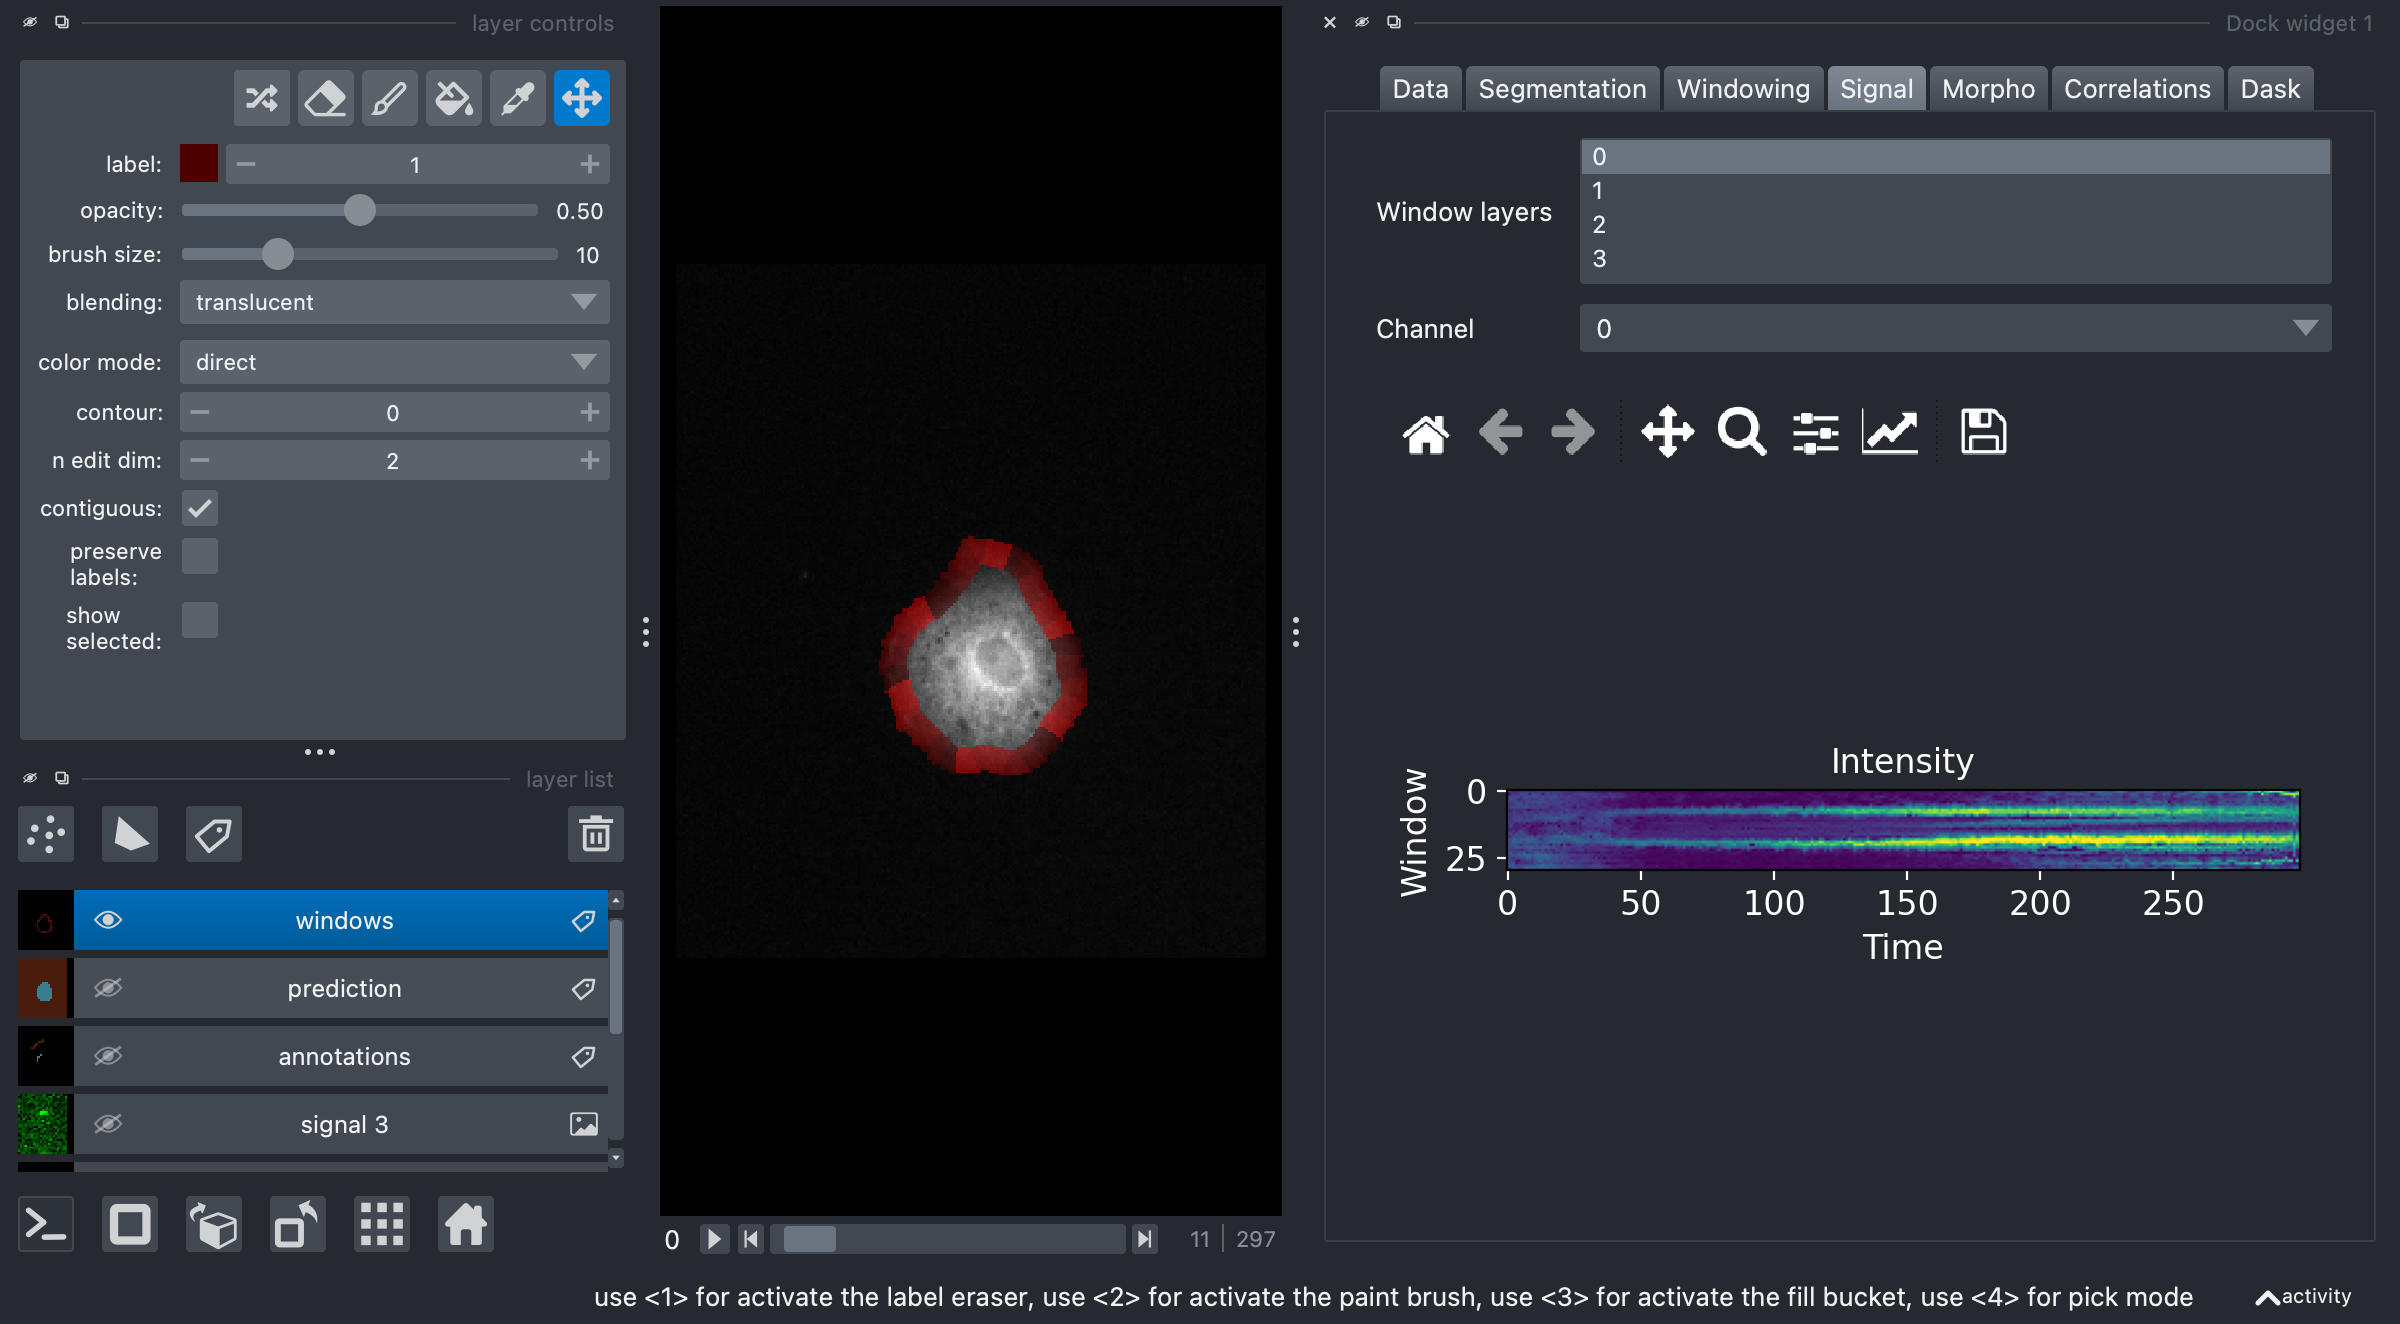

In [11]:
self.tabs.setCurrentIndex(3)
self.display_wlayers.setCurrentRow(0)
nbscreenshot(viewer)

In [13]:
for ax in self.intensity_plot.canvas.figure.axes:
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.title.set_color('black')
    ax.tick_params(colors='black')
self.intensity_plot.canvas.figure.axes[0].set_xlim(0,150)
self.intensity_plot.figure.savefig('images/intensity.png')

In the ```Morpho``` tab we can visualize cell morphology plots. For example we can follow the cumulative displacement of the cell contour:

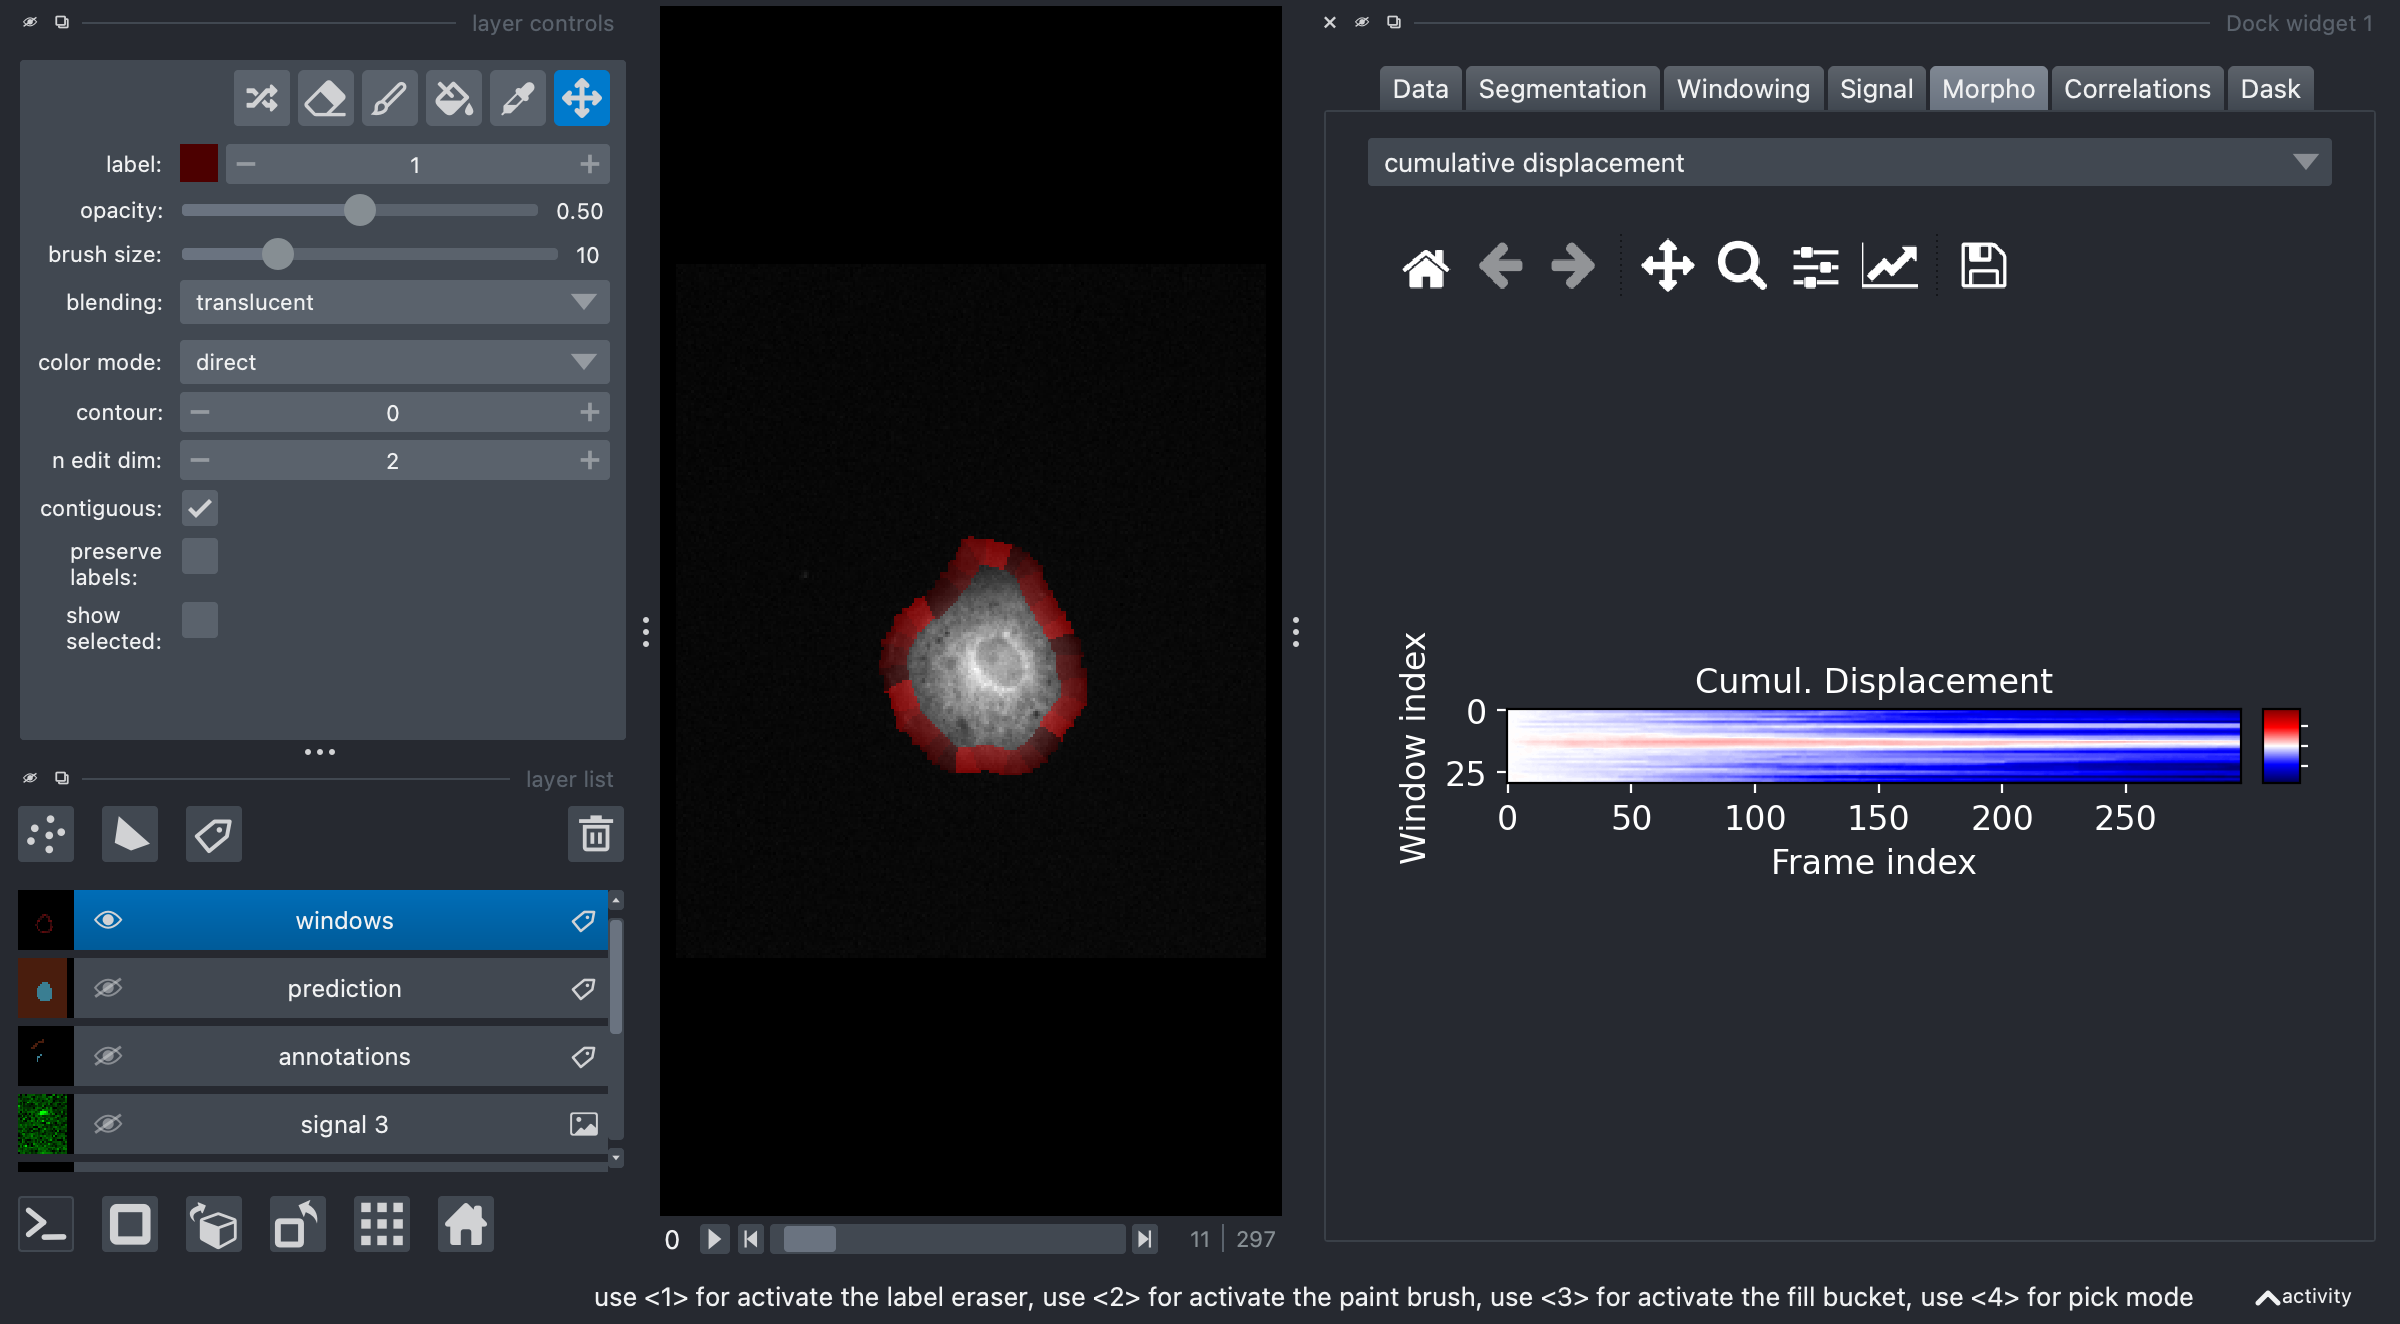

In [15]:
self.tabs.setCurrentIndex(4)
self.drop_choose_plot.setCurrentIndex(1)
nbscreenshot(viewer)

In [19]:
#self.displacement_plot.canvas.figure.set_facecolor(np.array((38, 41, 48))/255)
self.displacement_plot.canvas.figure.set_facecolor('white')
for ax in self.displacement_plot.canvas.figure.axes:
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.title.set_color('black')
    ax.tick_params(colors='black')
self.displacement_plot.canvas.figure.axes[0].set_xlim(0,150)
self.displacement_plot.figure.savefig('images/displacement.png')

Or we can superpose all contours on the first movie frame:

In [20]:
gray = np.array((38, 41, 48))/255
self.displacement_plot.canvas.figure.set_facecolor(gray)
for ax in self.displacement_plot.canvas.figure.axes:
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(colors='white')
self.displacement_plot.canvas.figure.axes[0].set_xlim(-0.5, 296.5)

self.drop_choose_plot.setCurrentIndex(3)
viewer.screenshot('images/napari_morphodynamics_snapshot.png', canvas_only=False);

/Users/gw18g940/GoogleDrive/BernMIC/Projects/MorphoDynamics/morphodynamics/plots/show_plots.py:137: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 640x480 with 0 Axes>

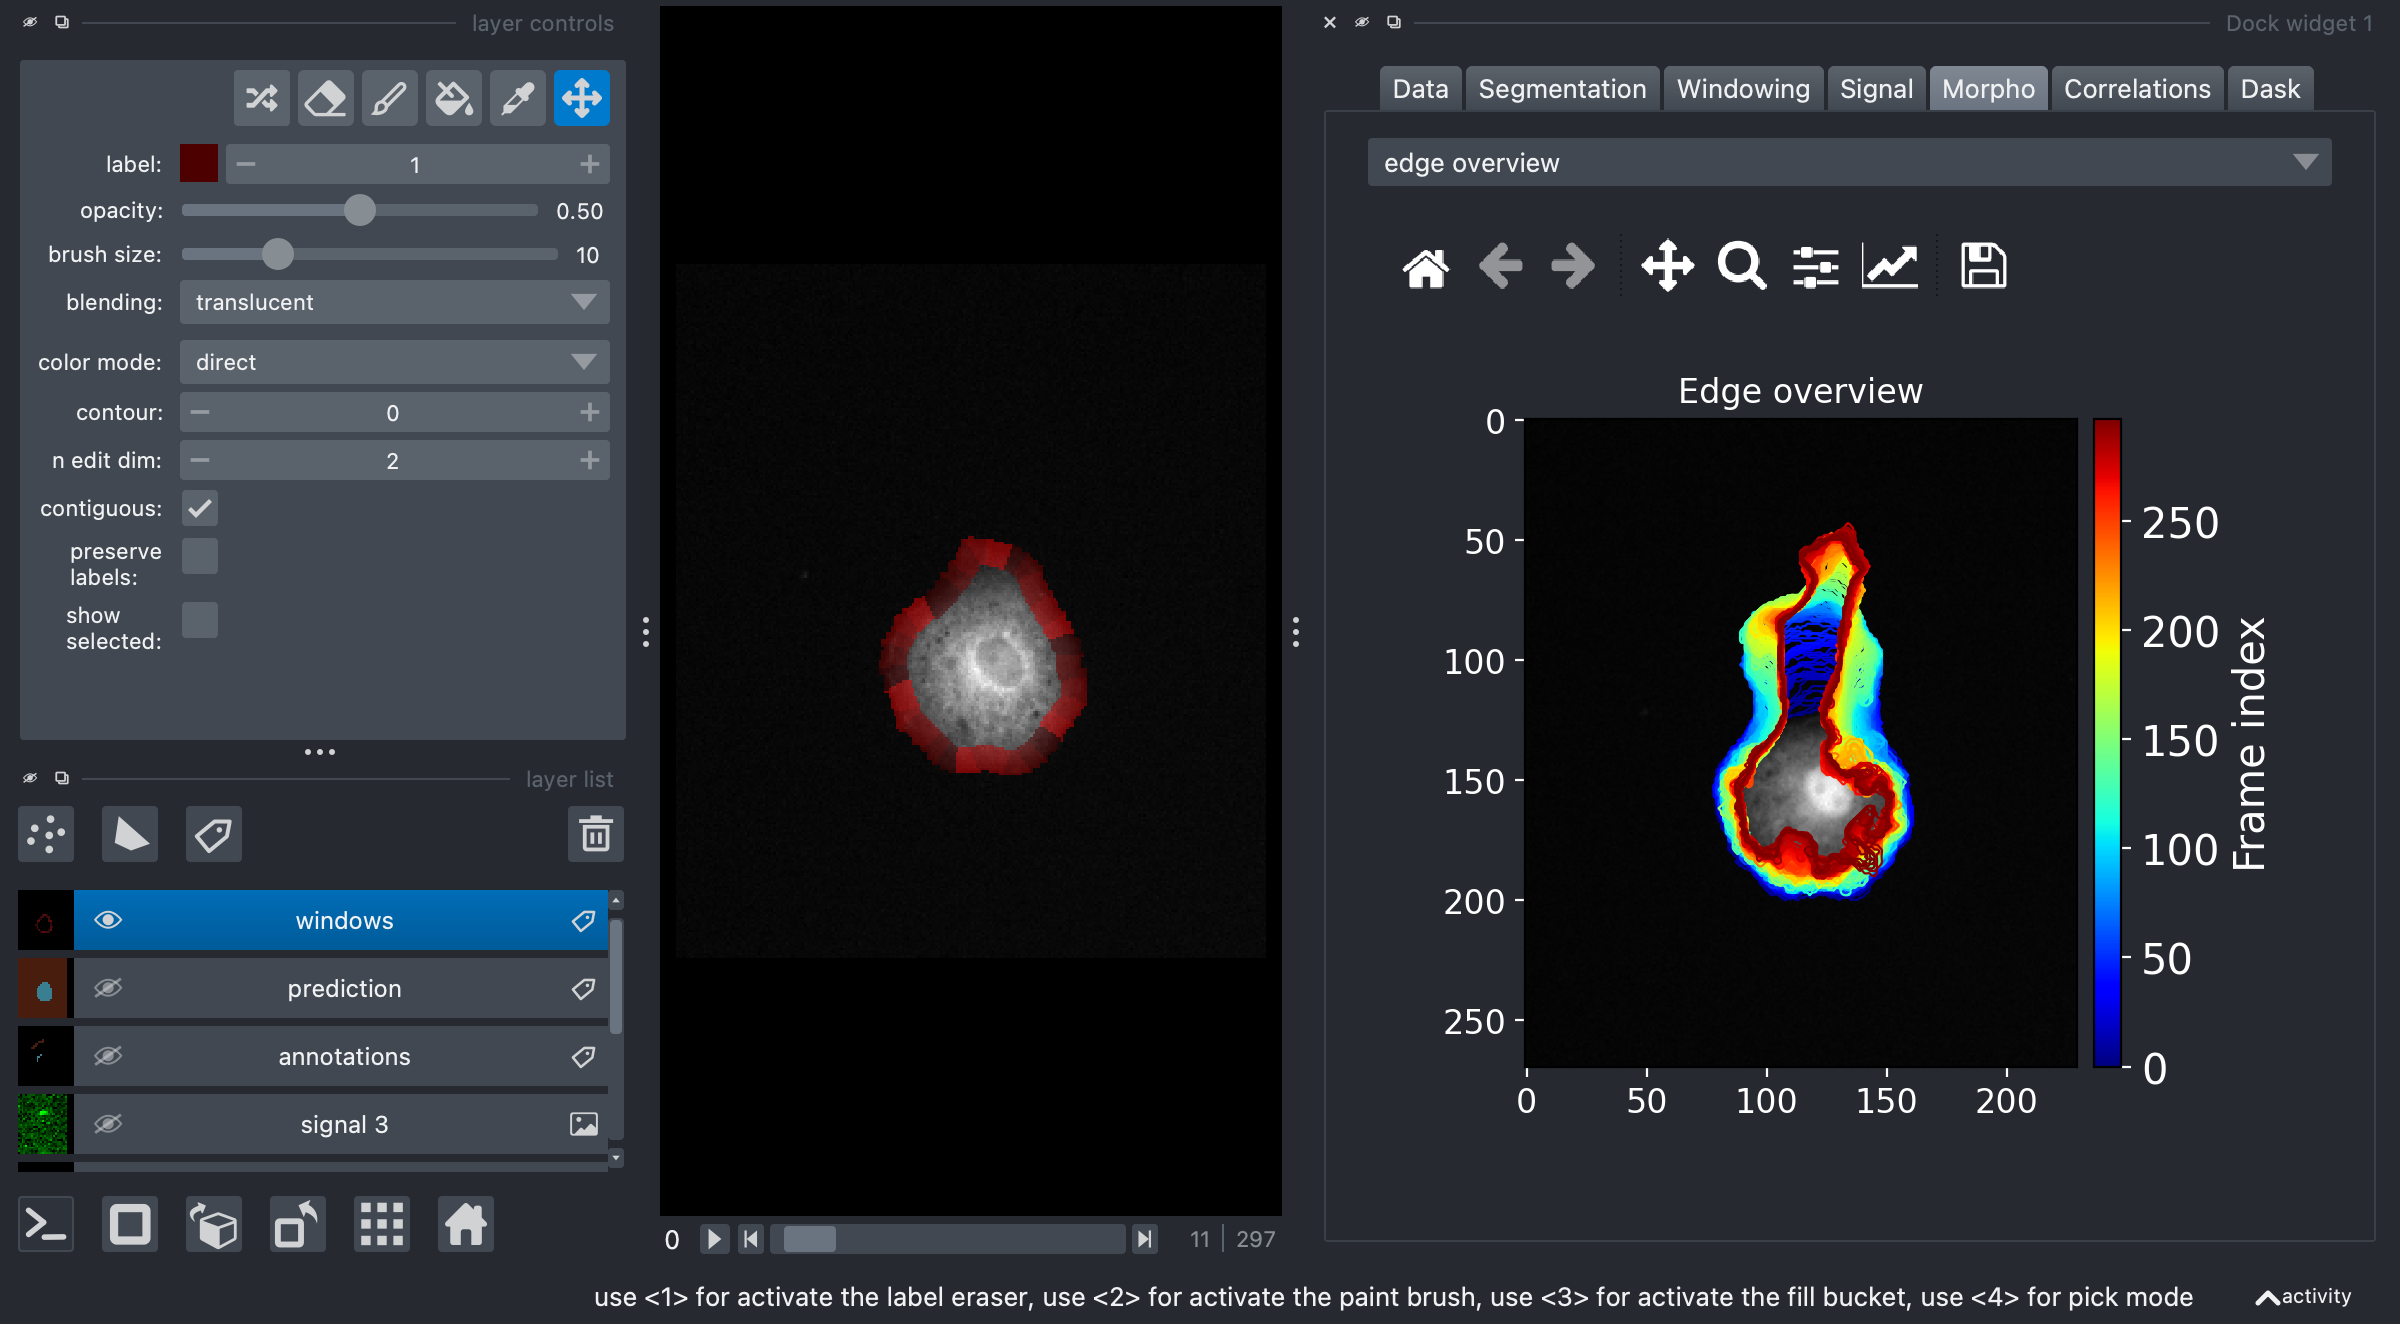

In [21]:
nbscreenshot(viewer)

Finally, in the ```Correlations``` tab, we can explore correlations between different channels (do certain signals move in concerted or delayed way?) or between cell contour displacement and signal (is there a correlation between cell movement and presence of a signal?):

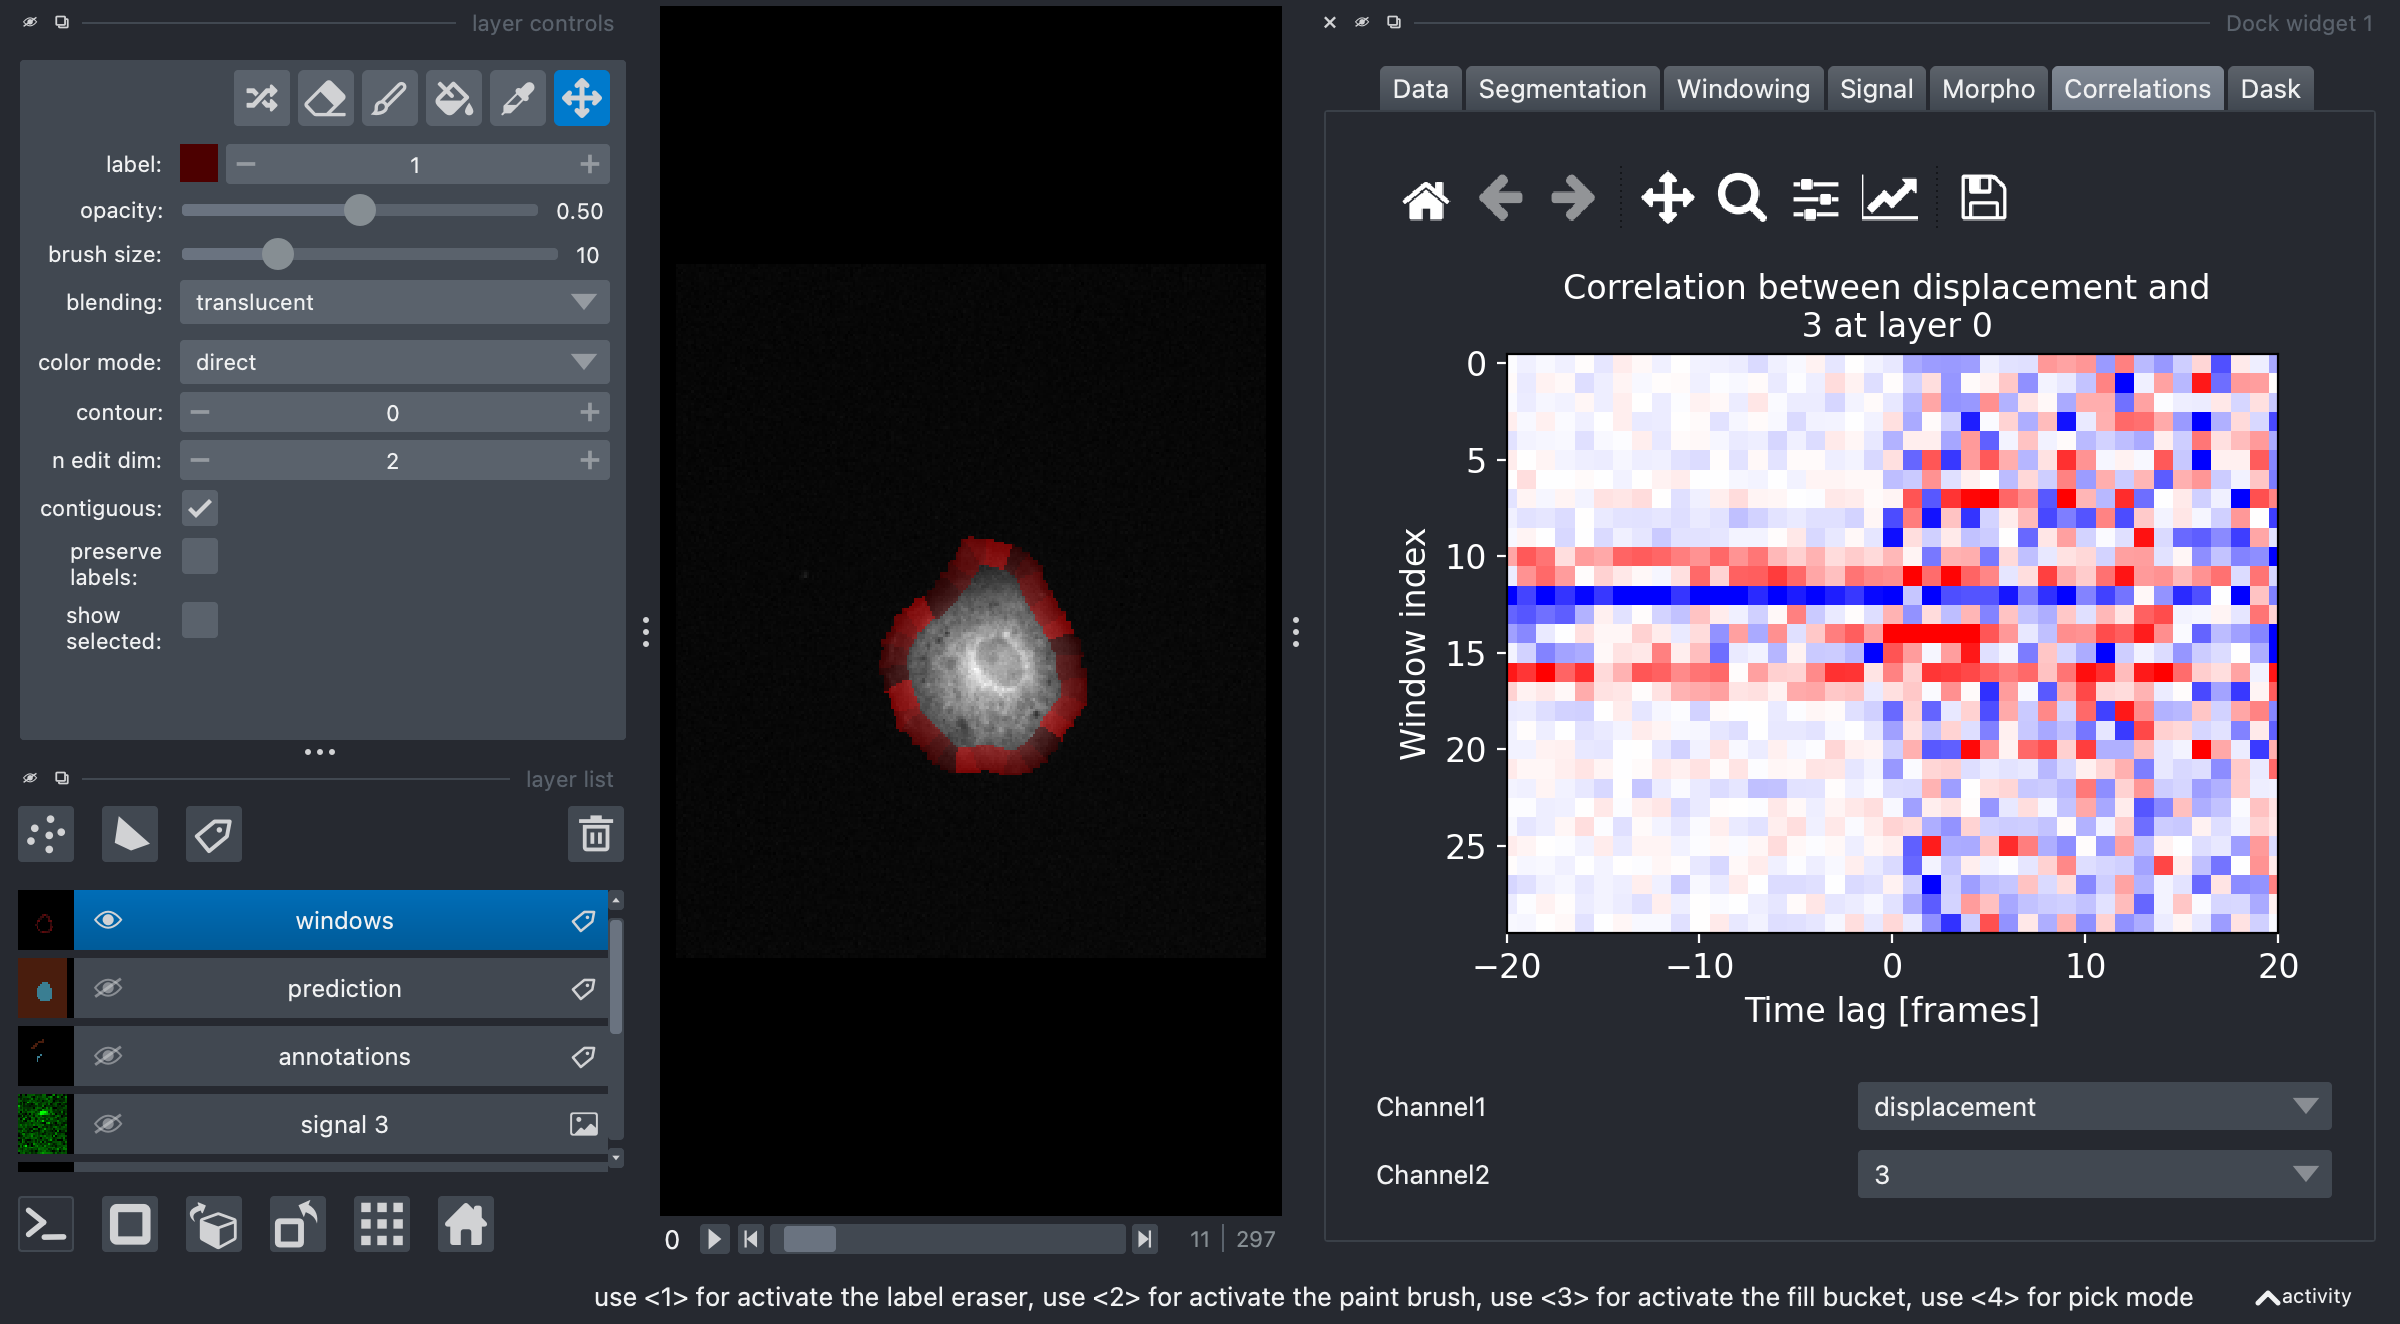

In [23]:
self.tabs.setCurrentIndex(5)
self.combo_channel_correlation2.setCurrentIndex(3)
self.combo_channel_correlation1.setCurrentText('displacement')
self.correlation_plot.canvas.figure.axes[0].set_xlim(-20,20)
self.correlation_plot.canvas.draw()
nbscreenshot(viewer)

In [24]:
self.correlation_plot.canvas.figure.set_facecolor('white')
for ax in self.correlation_plot.canvas.figure.axes:
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.title.set_color('black')
    ax.tick_params(colors='black')
self.correlation_plot.figure.savefig('images/correlation.png')